In [1]:
import pandas as pd
import numpy as np 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
pd.options.display.max_columns = 999

In [2]:
! cd ../data; ls;

Data_Dictionary.xlsx          sample_submission.csv
historical_transactions.csv   test.csv
merchants.csv                 train.csv
new_merchant_transactions.csv


In [3]:
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

In [36]:
histroical_transaction = pd.read_csv("../data/historical_transactions.csv", 
                             parse_dates=['purchase_date'])
merchants = pd.read_csv("../data/merchants.csv")
new_transaction = pd.read_csv("../data/new_merchant_transactions.csv", 
                              parse_dates=['purchase_date'])

In [5]:
%%time
histroical_transaction = binarize(histroical_transaction)
new_transaction = binarize(new_transaction)

CPU times: user 4.96 s, sys: 1.27 s, total: 6.23 s
Wall time: 6.32 s


In [6]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

In [9]:
train = read_data('../data/train.csv')
test = read_data('../data/test.csv')

target = train['target']

In [8]:
histroical_transaction.tail()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
29112356,1,C_ID_2863d2fa95,-1,1,1,B,360,M_ID_edd92b6720,-1,-0.632706,2017-01-20 08:52:04,NaN,-1,34
29112357,1,C_ID_2863d2fa95,-1,1,1,B,360,M_ID_edd92b6720,0,-0.632706,2017-02-20 04:40:50,NaN,-1,34
29112358,1,C_ID_5c240d6e3c,3,0,0,A,278,M_ID_9cdcfe8673,0,-0.657740,2017-12-26 18:37:51,1.0,16,37
29112359,1,C_ID_5c240d6e3c,331,0,0,A,514,M_ID_1a75f94f92,-1,0.770620,2017-11-24 14:18:15,1.0,16,9
29112360,1,C_ID_5c240d6e3c,331,0,0,A,514,M_ID_1a75f94f92,-2,1.134411,2017-10-26 14:09:40,1.0,16,9


In [14]:
train.tail()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time
201912,2017-09-01,C_ID_963962de2c,3,2,1,-2.740821,153
201913,2015-10-01,C_ID_1314773c0b,3,1,1,0.312917,854
201914,2017-08-01,C_ID_7666735b3d,4,3,0,0.093494,184
201915,2016-07-01,C_ID_73f5a0efd0,3,2,1,-4.676589,580
201916,2017-07-01,C_ID_92c9984c58,3,1,1,-1.859413,215


In [10]:
print('Number of rows and columns in train', train.shape)
print('Number of rows and columns in test', test.shape)

Number of rows and columns in train (201917, 7)
Number of rows and columns in test (123623, 6)


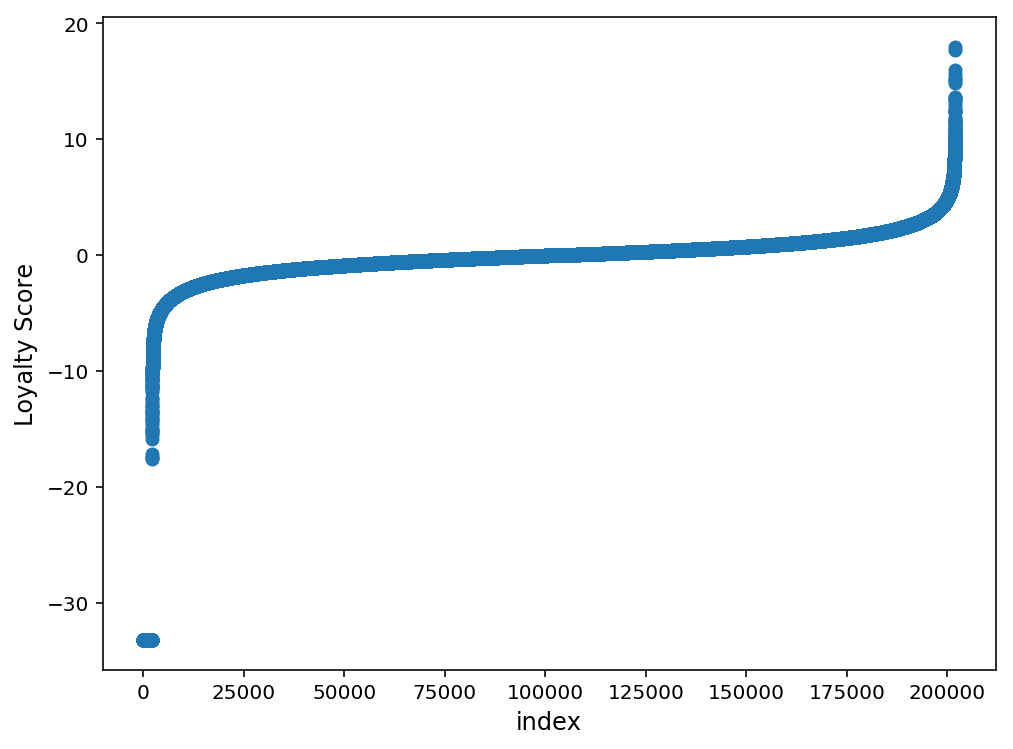

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

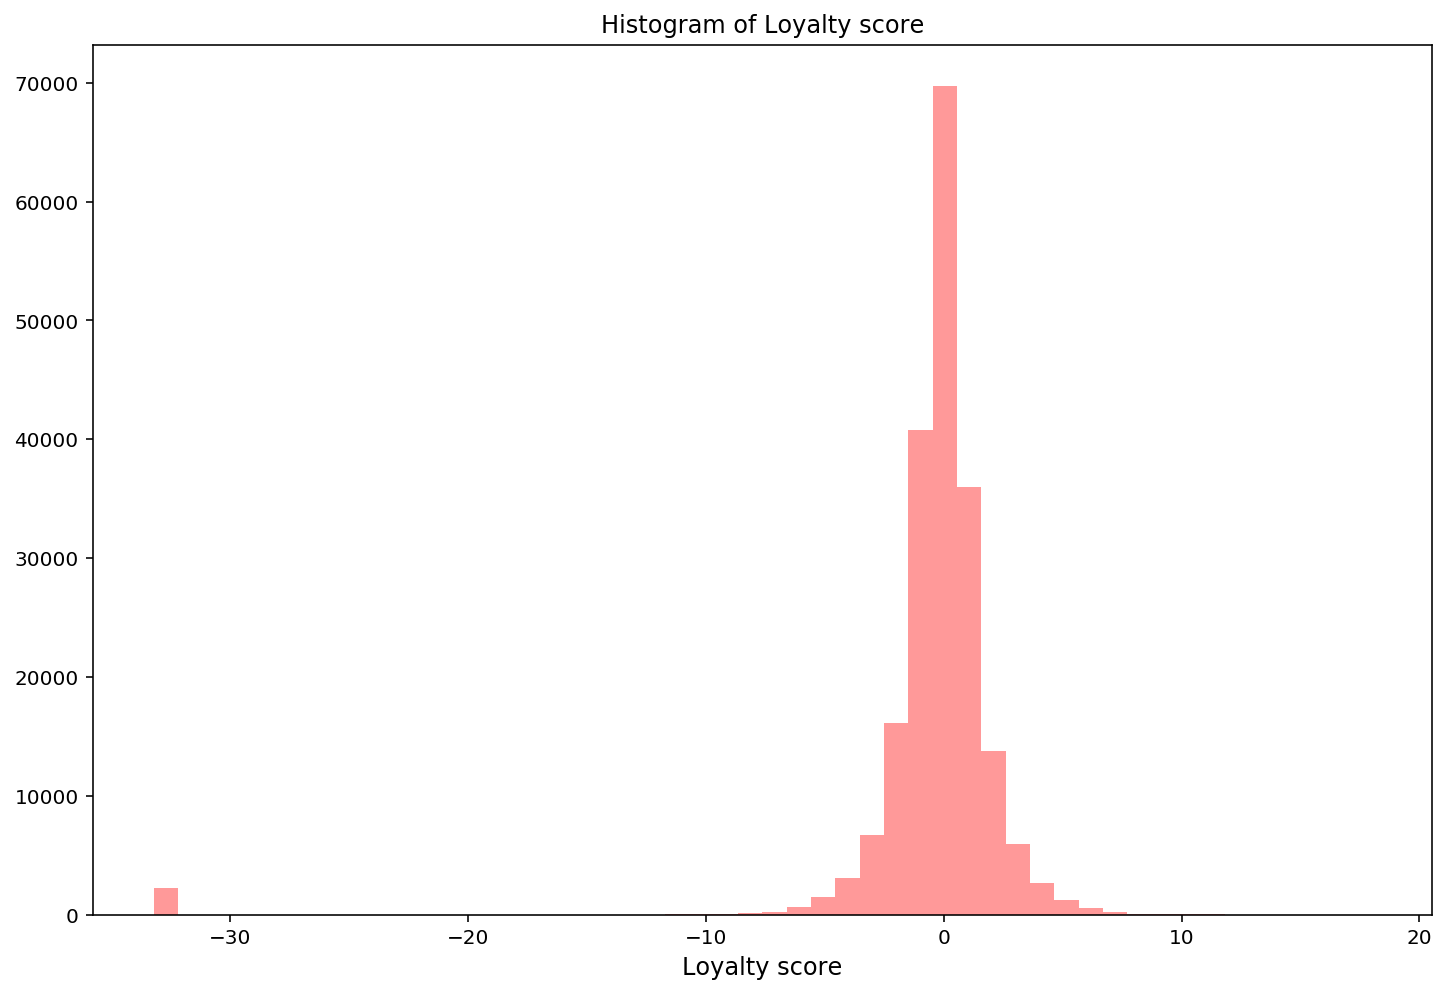

In [12]:
plt.figure(figsize=(12,8))
sns.distplot(train['target'].values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

In [13]:
(train['target']<-30).sum()
# 데이터의 1%정도가 마이너스..

2207

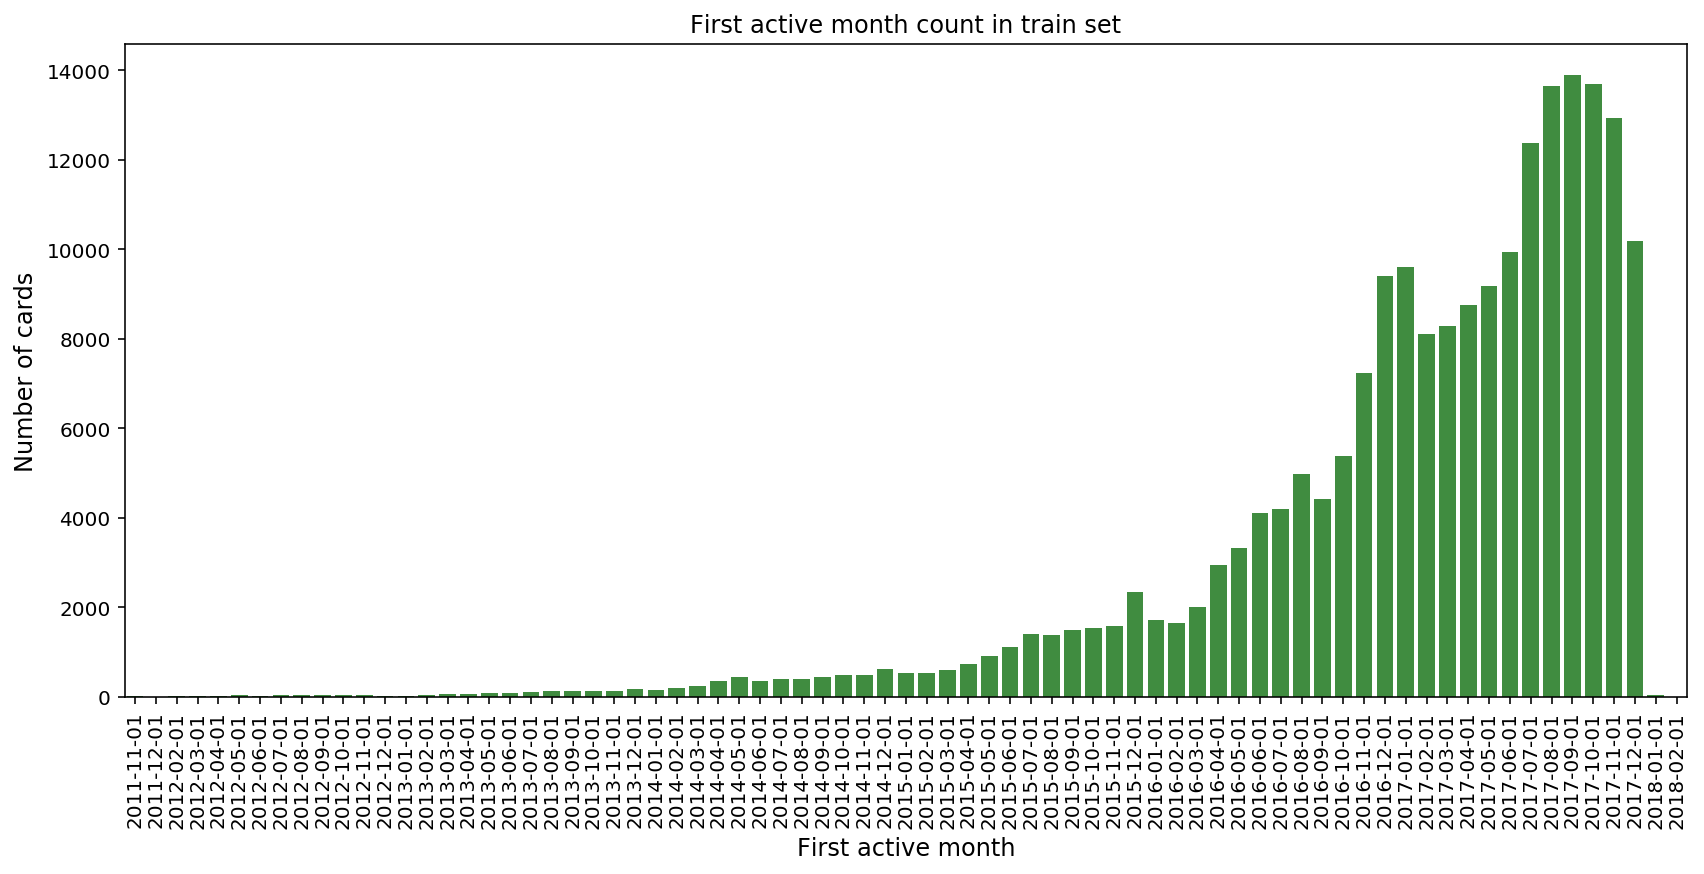

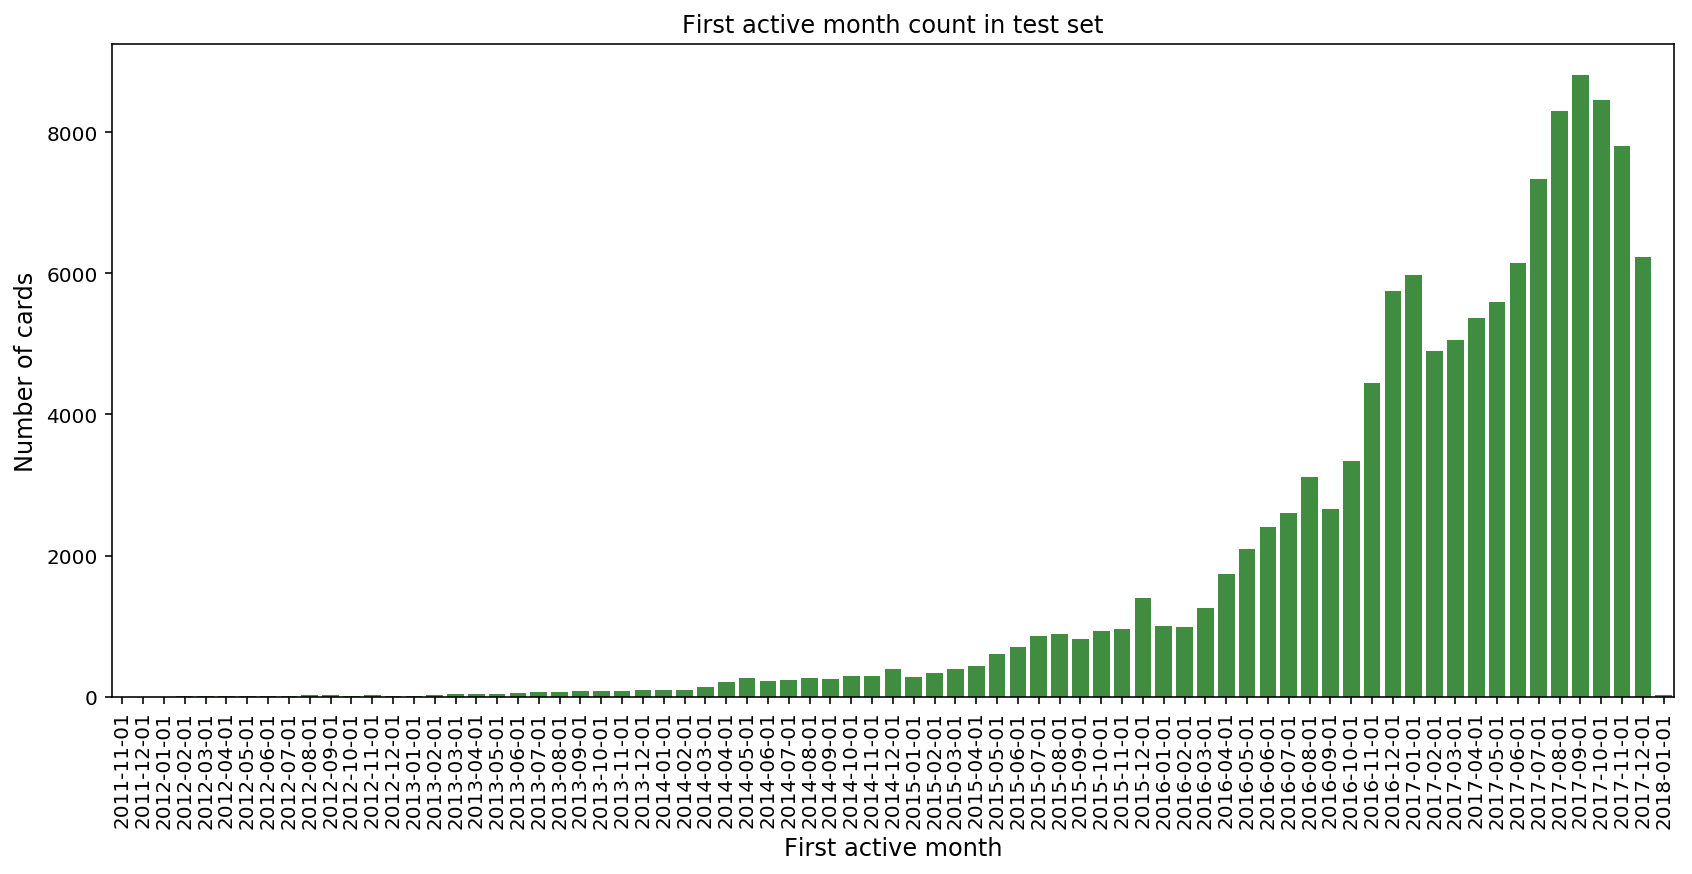

In [15]:
cnt_srs = train['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = test['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

In [16]:
train['feature_1'] = train['feature_1'].astype('category')
train['feature_2'] = train['feature_2'].astype('category')
train['feature_3'] = train['feature_3'].astype('category')

test['feature_1'] = test['feature_1'].astype('category')
test['feature_2'] = test['feature_2'].astype('category')
test['feature_3'] = test['feature_3'].astype('category')

In [17]:
d1 = train['first_active_month'].value_counts().sort_index()
d2 = test['first_active_month'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Counts of first active",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

- 분포 유사해보임

### Feature

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



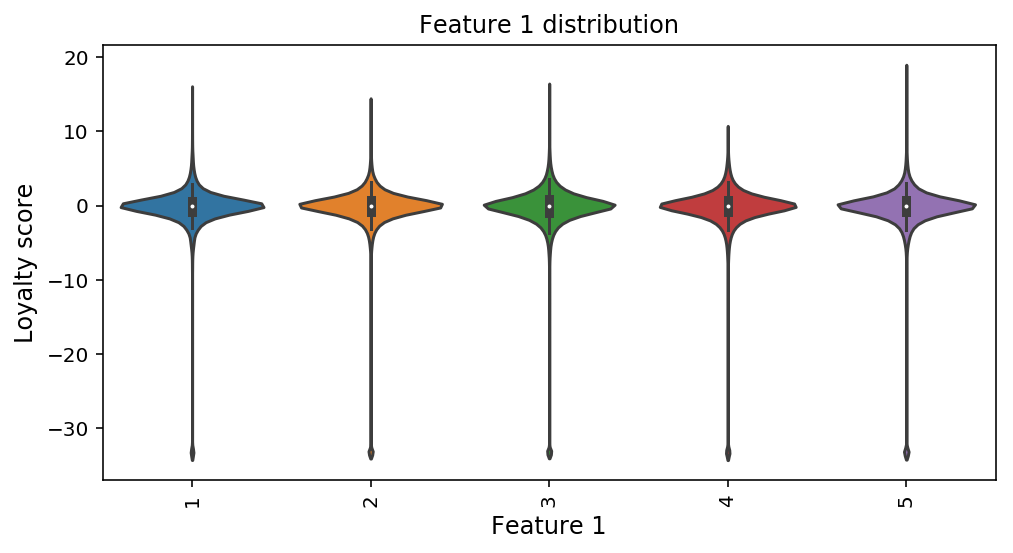

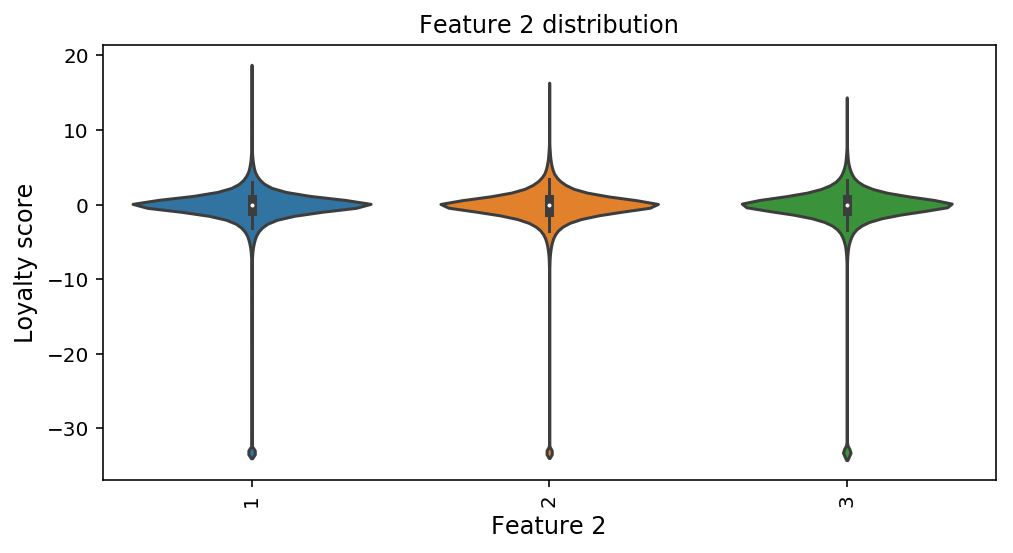

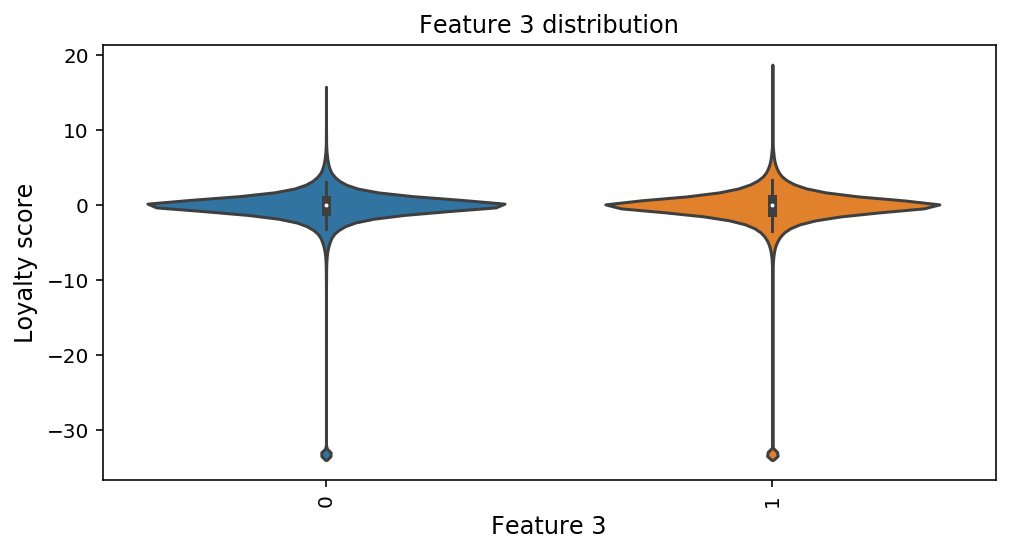

In [18]:
# feature 1
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_1", y='target', data=train)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
plt.show()

# feature 2
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_2", y='target', data=train)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 2 distribution")
plt.show()

# feature 3
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_3", y='target', data=train)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 3 distribution")
plt.show()

- 분포가 비슷한 느낌

In [138]:
histroical_transaction.tail()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
29112356,1,C_ID_2863d2fa95,-1,1,1,B,360,M_ID_edd92b6720,-1,-0.632706,2017-01-20 08:52:04,NaN,-1,34
29112357,1,C_ID_2863d2fa95,-1,1,1,B,360,M_ID_edd92b6720,0,-0.632706,2017-02-20 04:40:50,NaN,-1,34
29112358,1,C_ID_5c240d6e3c,3,0,0,A,278,M_ID_9cdcfe8673,0,-0.657740,2017-12-26 18:37:51,1.0,16,37
29112359,1,C_ID_5c240d6e3c,331,0,0,A,514,M_ID_1a75f94f92,-1,0.770620,2017-11-24 14:18:15,1.0,16,9
29112360,1,C_ID_5c240d6e3c,331,0,0,A,514,M_ID_1a75f94f92,-2,1.134411,2017-10-26 14:09:40,1.0,16,9


- card_id - Card identifier
- month_lag - month lag to reference date
- purchase_date - Purchase date
- authorized_flag - 'Y' if approved, 'N' if denied
- category_3 - anonymized category
- installments - number of installments of purchase
- category_1 - anonymized category
- merchant_category_id - Merchant category identifier (anonymized )
- subsector_id - Merchant category group identifier (anonymized )
- merchant_id - Merchant identifier (anonymized)
- purchase_amount - Normalized purchase amount
- city_id - City identifier (anonymized )
- state_id - State identifier (anonymized )
- category_2 - anonymized category

In [19]:
gdf = histroical_transaction.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_hist_transactions"]
train_df = pd.merge(train, gdf, on="card_id", how="left")
test_df = pd.merge(test, gdf, on="card_id", how="left")

In [20]:
gdf.head()

,card_id,num_hist_transactions
0,C_ID_00007093c1,149
1,C_ID_0001238066,123
2,C_ID_0001506ef0,66
3,C_ID_0001793786,216
4,C_ID_000183fdda,144


In [21]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time,num_hist_transactions
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,260
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,396,350
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,549,43
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,153,77
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,92,133


In [142]:
cnt_srs = train_df.groupby("num_hist_transactions")['target'].mean()
cnt_srs = cnt_srs.sort_index()
cnt_srs = cnt_srs[:-50]

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

trace = scatter_plot(cnt_srs, "orange")
layout = dict(
    title='Loyalty score by Number of historical transactions',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="Histtranscnt")

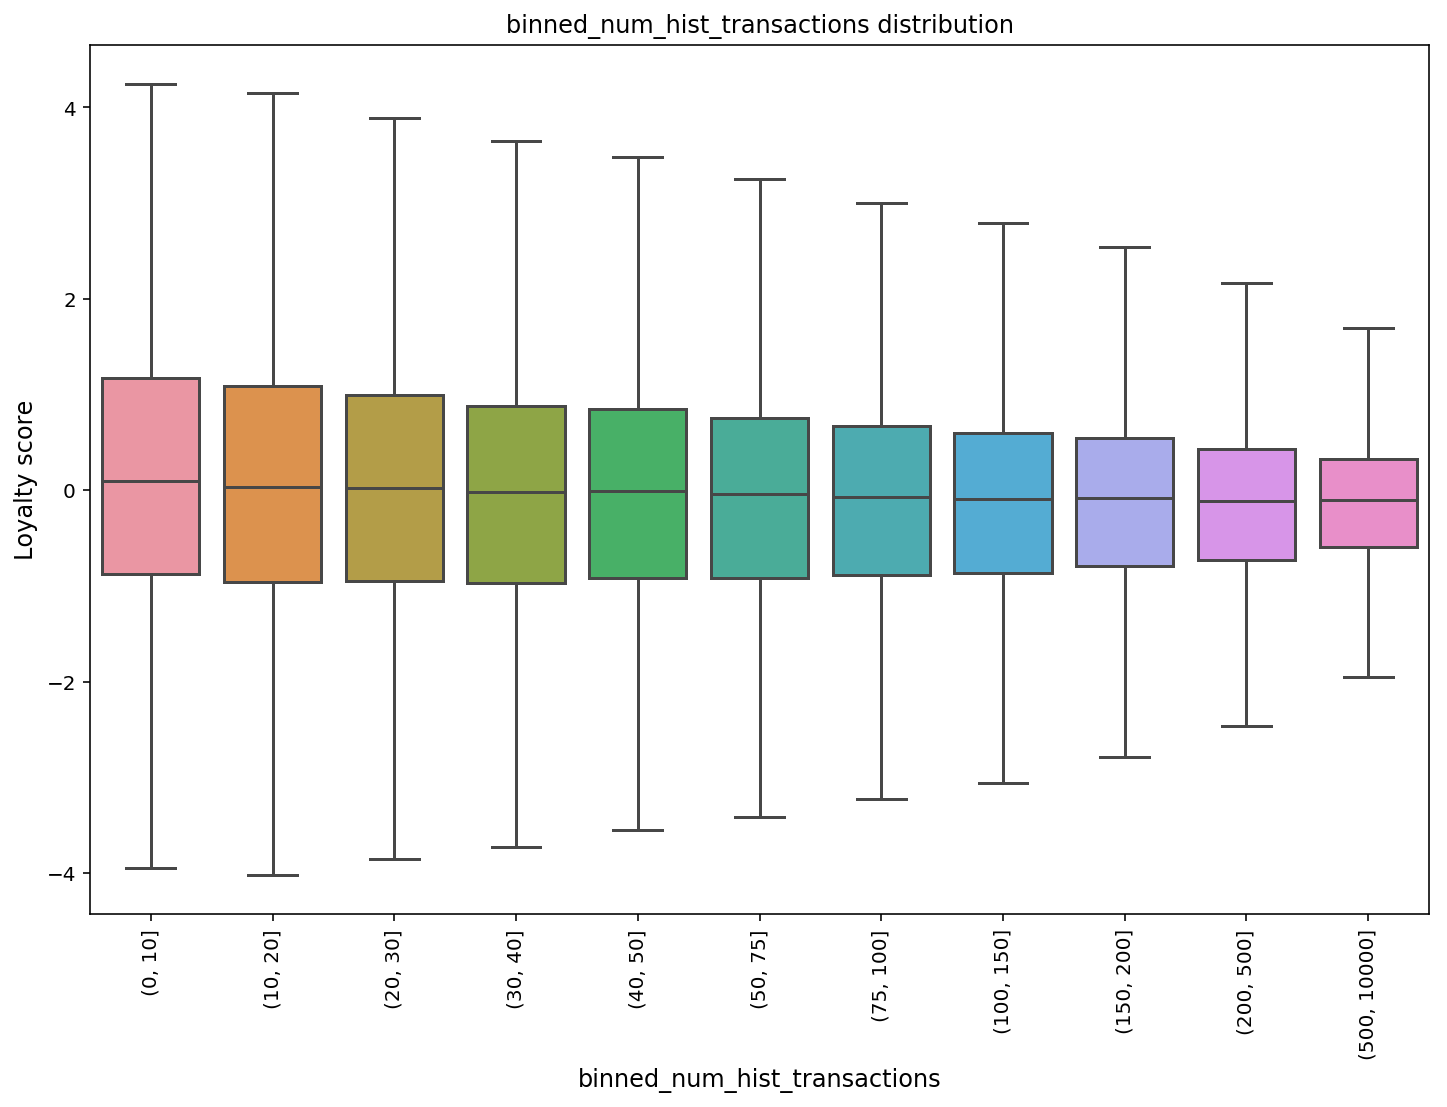

In [22]:
bins = [0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 500, 10000]
train_df['binned_num_hist_transactions'] = pd.cut(train_df['num_hist_transactions'], bins)
cnt_srs = train_df.groupby("binned_num_hist_transactions")['target'].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_hist_transactions", y='target', data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_hist_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("binned_num_hist_transactions distribution")
plt.show()

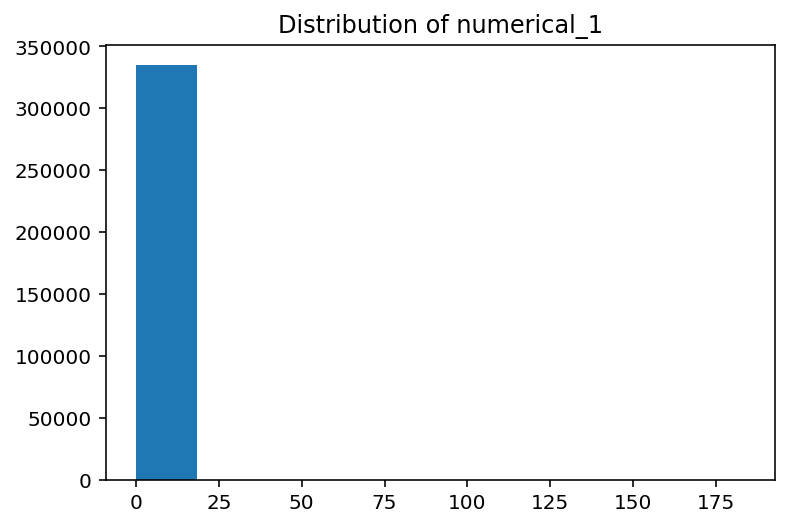

In [37]:
plt.hist(merchants['numerical_1']);
plt.title('Distribution of numerical_1');

In [38]:
np.percentile(merchants['numerical_1'], 95)

0.09125291

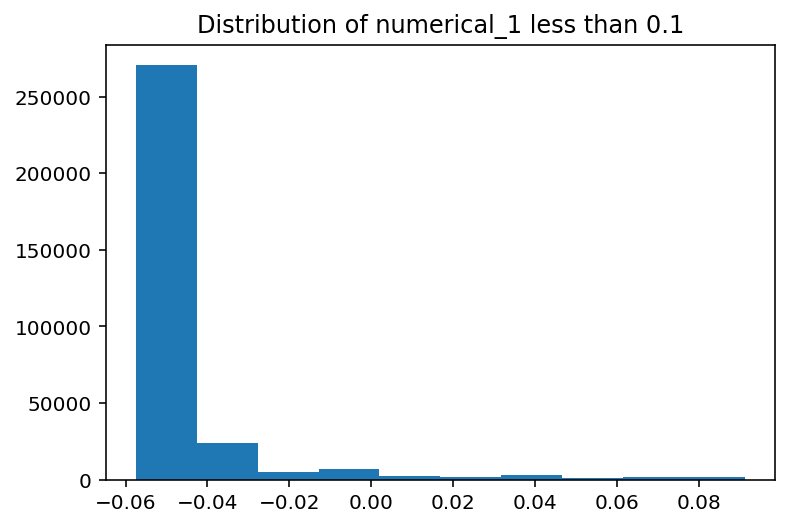

In [39]:
plt.hist(merchants.loc[merchants['numerical_1'] < 0.1, 'numerical_1']);
plt.title('Distribution of numerical_1 less than 0.1');

In [40]:
min_n1 = merchants['numerical_1'].min()
_ = sum(merchants['numerical_1'] == min_n1) / merchants['numerical_1'].shape[0]
print(f'{_ * 100:.4f}% of values in numerical_1 are equal to {min_n1}')

68.3570% of values in numerical_1 are equal to -0.05747065


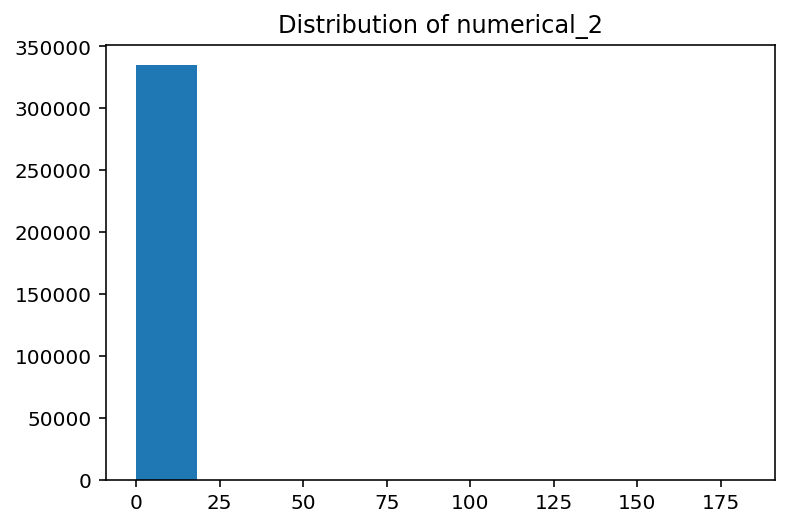

In [41]:
plt.hist(merchants['numerical_2']);
plt.title('Distribution of numerical_2');

68.3570% of values in numerical_1 are equal to -0.05747065


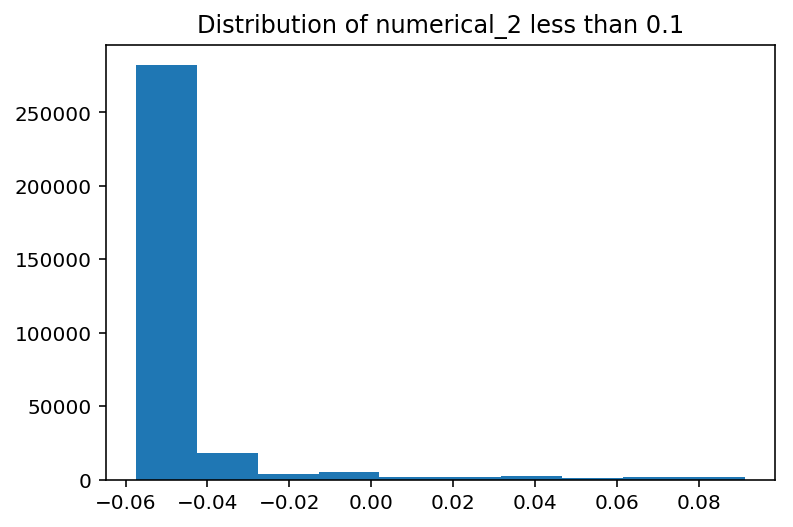

In [42]:
plt.hist(merchants.loc[merchants['numerical_2'] < 0.1, 'numerical_2']);
plt.title('Distribution of numerical_2 less than 0.1');
min_n1 = merchants['numerical_1'].min()
_ = sum(merchants['numerical_1'] == min_n1) / merchants['numerical_1'].shape[0]
print(f'{_ * 100:.4f}% of values in numerical_1 are equal to {min_n1}')

In [43]:
(merchants['numerical_1'] != merchants['numerical_2']).sum() / merchants.shape[0]

0.10056289886942181

### most_recent_sales_range

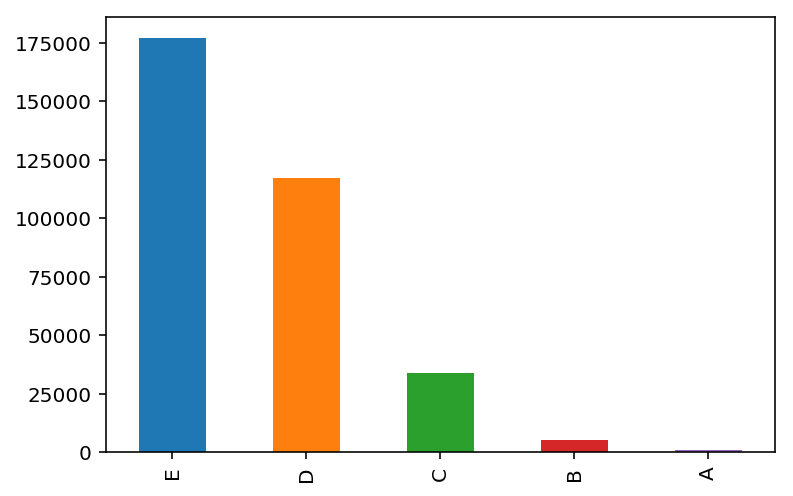

In [44]:
merchants['most_recent_sales_range'].value_counts().plot('bar');

In [45]:
d = merchants['most_recent_sales_range'].value_counts().sort_index()
e = merchants.loc[merchants['numerical_2'] < 0.1].groupby('most_recent_sales_range')['numerical_1'].mean()
data = [go.Bar(x=d.index, y=d.values, name='counts'), go.Scatter(x=e.index, y=e.values, name='mean numerical_1', yaxis='y2')]
layout = go.Layout(dict(title = "Counts of values in categories of most_recent_sales_range",
                        xaxis = dict(title = 'most_recent_sales_range'),
                        yaxis = dict(title = 'Counts'),
                        yaxis2=dict(title='mean numerical_1', overlaying='y', side='right')),
                   legend=dict(orientation="v"))
py.iplot(dict(data=data, layout=layout))

### most_recent_purchases_range


In [46]:
d = merchants['most_recent_purchases_range'].value_counts().sort_index()
e = merchants.loc[merchants['numerical_2'] < 0.1].groupby('most_recent_purchases_range')['numerical_1'].mean()
data = [go.Bar(x=d.index, y=d.values, name='counts'), go.Scatter(x=e.index, y=e.values, name='mean numerical_1', yaxis='y2')]
layout = go.Layout(dict(title = "Counts of values in categories of most_recent_purchases_range",
                        xaxis = dict(title = 'most_recent_purchases_range'),
                        yaxis = dict(title = 'Counts'),
                        yaxis2=dict(title='mean numerical_1', overlaying='y', side='right')),
                   legend=dict(orientation="v"))
py.iplot(dict(data=data, layout=layout))


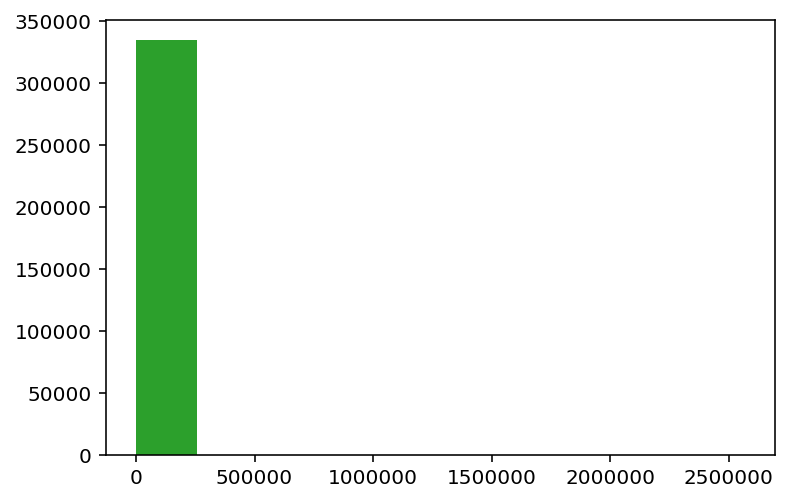

In [47]:
plt.hist(merchants['avg_sales_lag3'].fillna(0));
plt.hist(merchants['avg_sales_lag6'].fillna(0));
plt.hist(merchants['avg_sales_lag12'].fillna(0));

In [48]:
for col in ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']:
    print(f'Max value of {col} is {merchants[col].max()}')
    print(f'Min value of {col} is {merchants[col].min()}')

Max value of avg_sales_lag3 is 851844.64
Min value of avg_sales_lag3 is -82.13
Max value of avg_sales_lag6 is 1513959.0
Min value of avg_sales_lag6 is -82.13
Max value of avg_sales_lag12 is 2567408.0
Min value of avg_sales_lag12 is -82.13


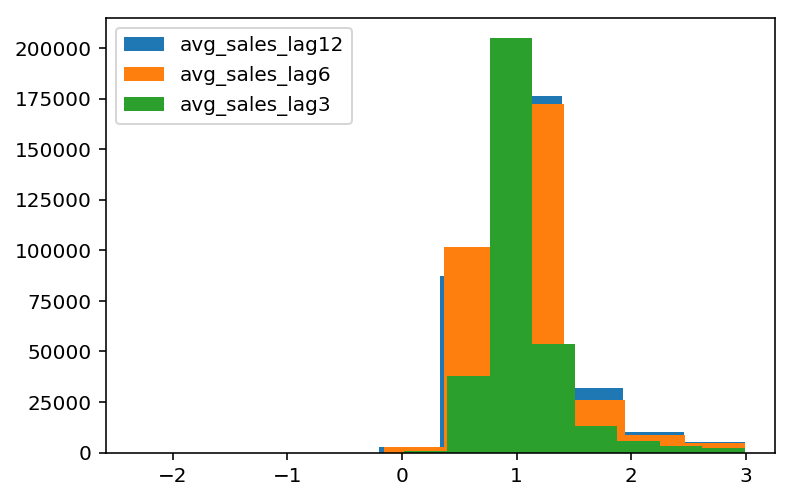

In [49]:
plt.hist(merchants.loc[(merchants['avg_sales_lag12'] < 3) & (merchants['avg_sales_lag12'] > -10), 'avg_sales_lag12'].fillna(0), label='avg_sales_lag12');
plt.hist(merchants.loc[(merchants['avg_sales_lag6'] < 3) & (merchants['avg_sales_lag6'] > -10), 'avg_sales_lag6'].fillna(0), label='avg_sales_lag6');
plt.hist(merchants.loc[(merchants['avg_sales_lag3'] < 3) & (merchants['avg_sales_lag3'] > -10), 'avg_sales_lag3'].fillna(0), label='avg_sales_lag3');
plt.legend();

In [23]:
gdf = histroical_transaction.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans"]
train_df = pd.merge(train, gdf, on="card_id", how="left")
test_df = pd.merge(test, gdf, on="card_id", how="left")

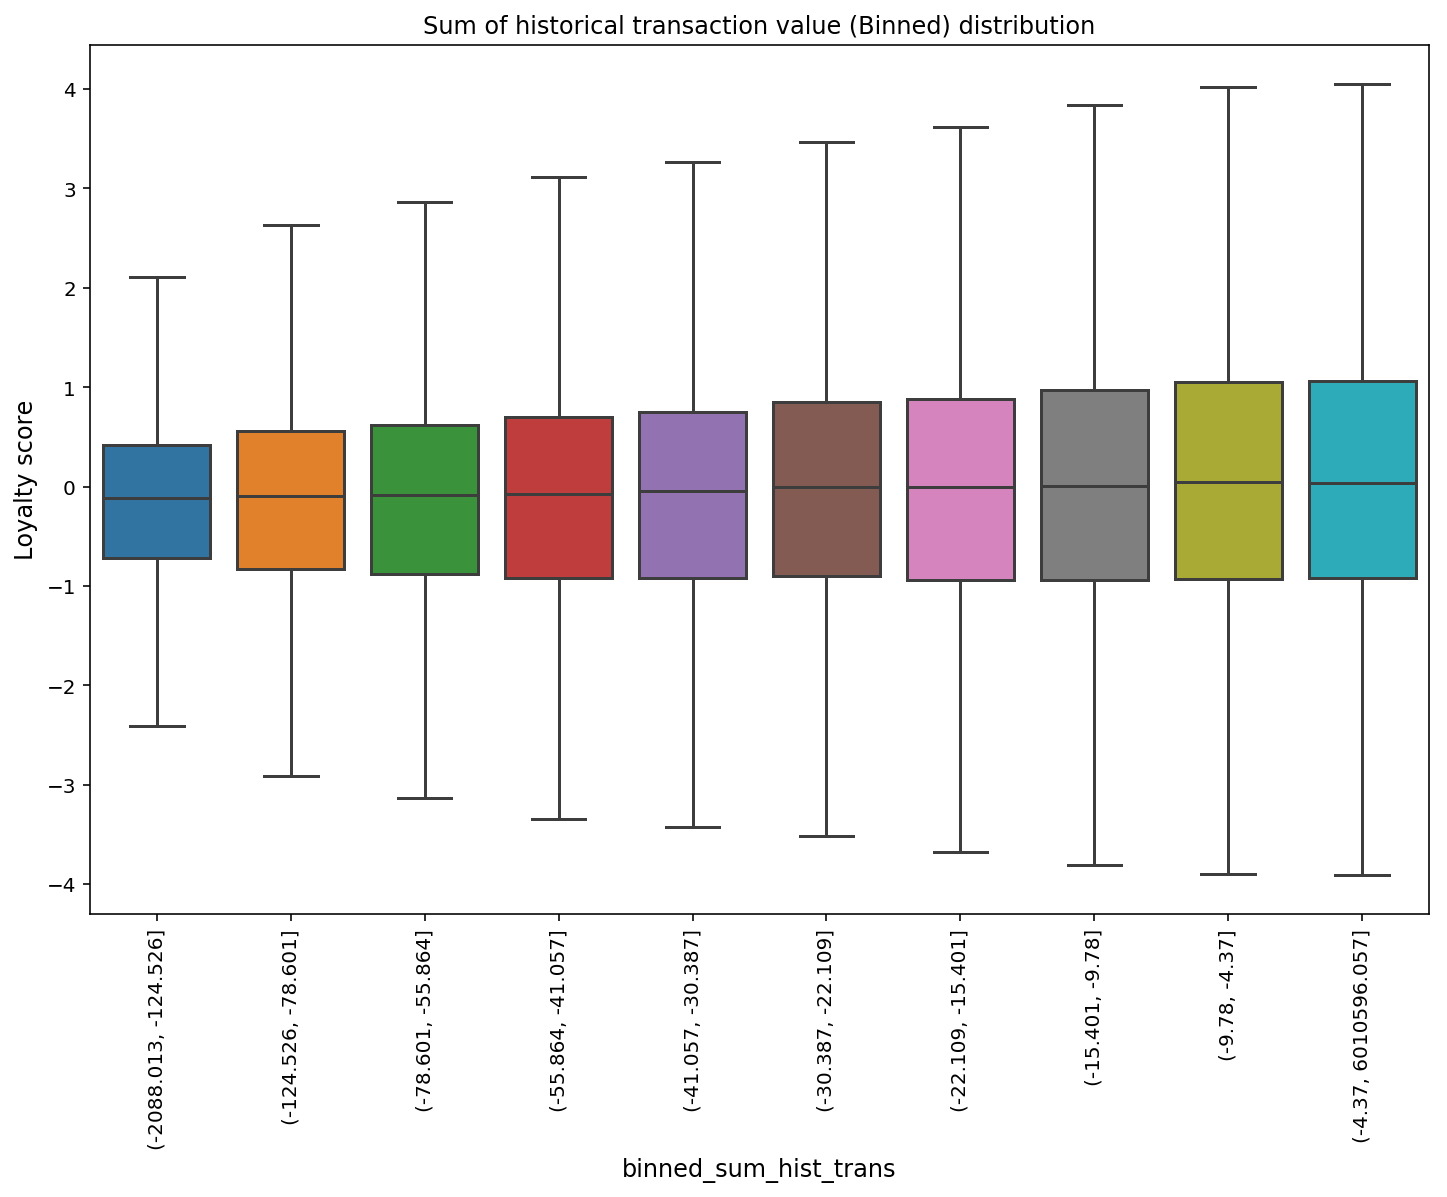

In [24]:
bins = np.percentile(train_df["sum_hist_trans"], range(0,101,10))
train_df['binned_sum_hist_trans'] = pd.cut(train_df['sum_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_hist_trans", y='target', data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_hist_trans', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of historical transaction value (Binned) distribution")
plt.show()

- loyalty score는 historical transaction value의 합으로 증가하는 듯

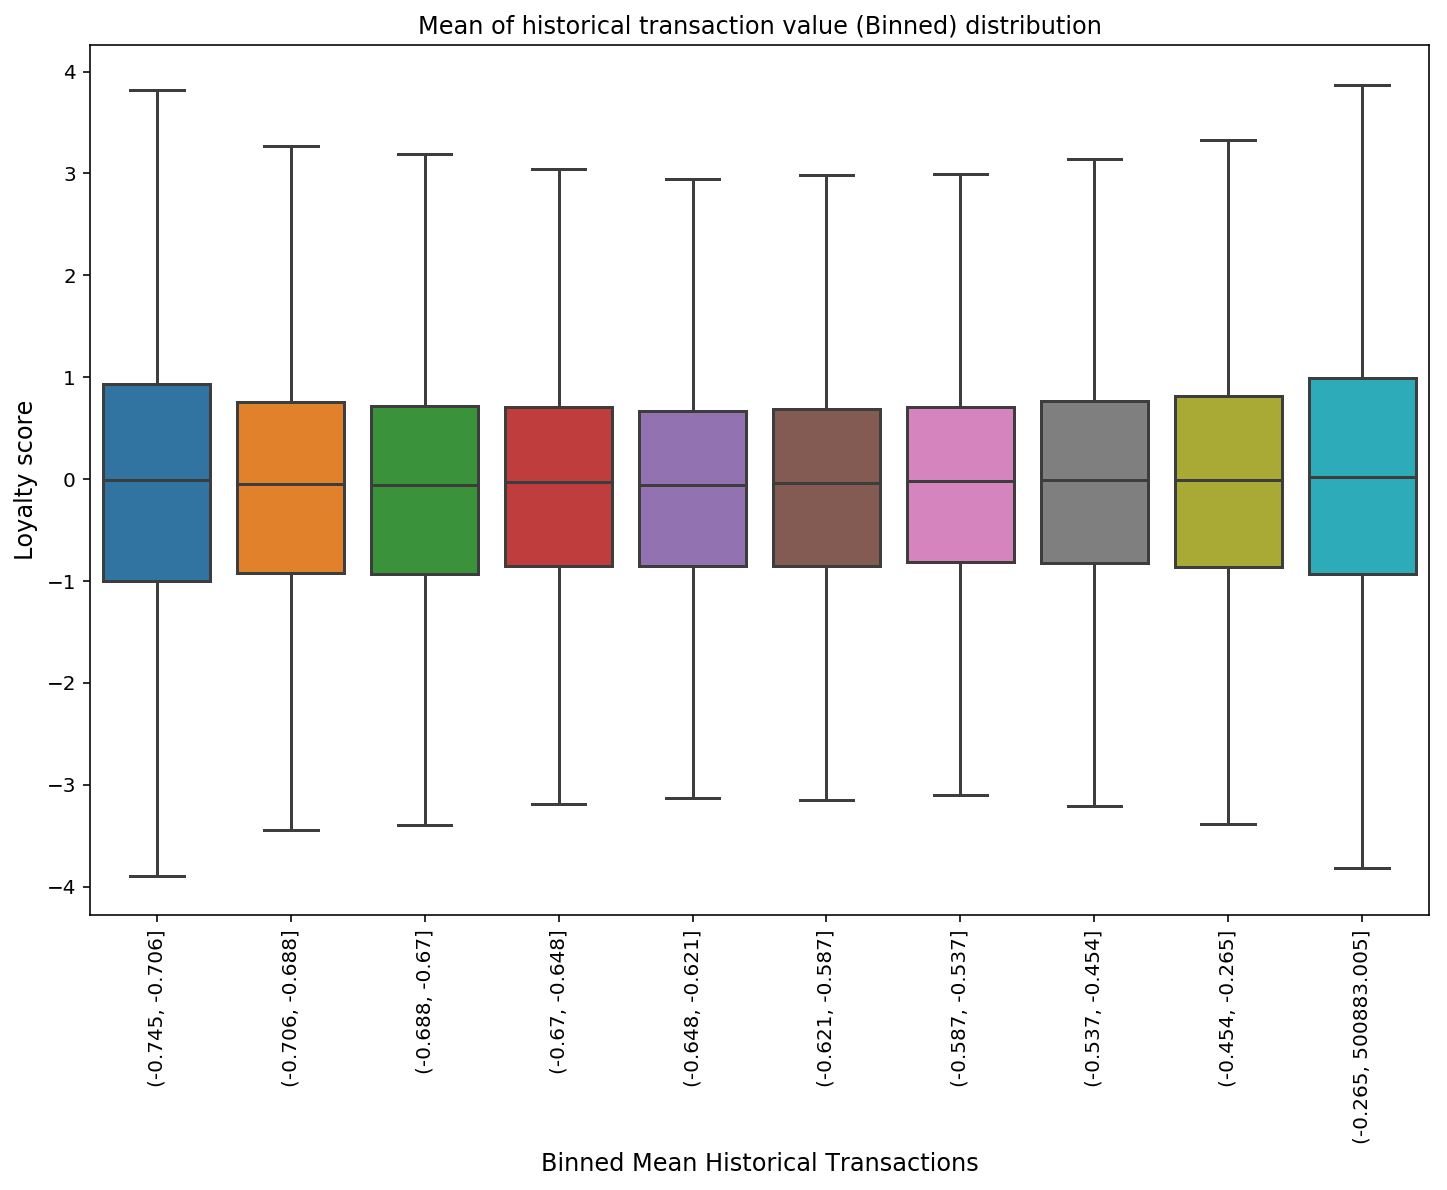

In [25]:
bins = np.percentile(train_df["mean_hist_trans"], range(0,101,10))
train_df['binned_mean_hist_trans'] = pd.cut(train_df['mean_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_mean_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_hist_trans", y='target', data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('Binned Mean Historical Transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of historical transaction value (Binned) distribution")
plt.show()

### new_merchant data

In [27]:
gdf = new_transaction.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_merch_trans", "mean_merch_trans", "std_merch_trans", "min_merch_trans", "max_merch_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [28]:
gdf.tail()

,card_id,sum_merch_trans,mean_merch_trans,std_merch_trans,min_merch_trans,max_merch_trans
289996,C_ID_ffff1d9928,-2.460351,-0.615088,0.219737,-0.729026,-0.285594
289997,C_ID_ffff579d3a,-0.664262,-0.664262,NaN,-0.664262,-0.664262
289998,C_ID_ffff756266,0.378578,0.378578,NaN,0.378578,0.378578
289999,C_ID_ffff828181,-4.964204,-0.620525,0.073003,-0.695427,-0.468166
290000,C_ID_fffffd5772,-2.125470,-0.708490,0.037231,-0.733985,-0.665765


In [29]:
train_df.tail()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time,sum_hist_trans,mean_hist_trans,std_hist_trans,min_hist_trans,max_hist_trans,binned_sum_hist_trans,binned_mean_hist_trans,sum_merch_trans,mean_merch_trans,std_merch_trans,min_merch_trans,max_merch_trans
201912,2017-09-01,C_ID_963962de2c,3,2,1,-2.740821,153,-32.625247,-0.709244,0.041394,-0.742400,-0.571909,"(-41.057, -30.387]","(-0.745, -0.706]",-0.693549,-0.693549,NaN,-0.693549,-0.693549
201913,2015-10-01,C_ID_1314773c0b,3,1,1,0.312917,854,-33.432922,-0.711339,0.039900,-0.743918,-0.574253,"(-41.057, -30.387]","(-0.745, -0.706]",-0.743902,-0.743902,NaN,-0.743902,-0.743902
201914,2017-08-01,C_ID_7666735b3d,4,3,0,0.093494,184,-33.187479,-0.381465,0.865067,-0.737922,6.015023,"(-41.057, -30.387]","(-0.454, -0.265]",-0.723797,-0.241266,0.392115,-0.663511,0.111407
201915,2016-07-01,C_ID_73f5a0efd0,3,2,1,-4.676589,580,-17.888957,-0.688037,0.034683,-0.731881,-0.609520,"(-22.109, -15.401]","(-0.688, -0.67]",1.930261,0.386052,1.511888,-0.721498,2.258395
201916,2017-07-01,C_ID_92c9984c58,3,1,1,-1.859413,215,-83.037556,-0.619683,0.240304,-0.740897,0.793310,"(-124.526, -78.601]","(-0.621, -0.587]",-3.580382,-0.447548,0.375683,-0.734887,0.162196


In [30]:
test_df.tail()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,sum_hist_trans,mean_hist_trans,std_hist_trans,min_hist_trans,max_hist_trans,sum_merch_trans,mean_merch_trans,std_merch_trans,min_merch_trans,max_merch_trans
123618,2017-10-01,C_ID_7a239d2eda,2,2,0,123.0,-49.404782,-0.676778,0.045208,-0.732197,-0.525387,NaN,NaN,NaN,NaN,NaN
123619,2017-09-01,C_ID_75ace375ae,3,1,1,153.0,-4.914616,-0.702088,0.056440,-0.736404,-0.578911,-2.658701,-0.664675,0.091129,-0.740897,-0.536687
123620,2016-09-01,C_ID_21d56d950c,5,1,1,518.0,-6.583716,-0.177938,0.520933,-0.698853,1.664306,NaN,NaN,NaN,NaN,NaN
123621,2017-06-01,C_ID_6c46fc5a9d,2,1,0,245.0,-39.123627,-0.631026,0.104634,-0.737892,-0.115794,-3.779889,-0.629981,0.074584,-0.707839,-0.498970
123622,2016-10-01,C_ID_87e7979a5f,5,1,1,488.0,-25.314203,-0.602719,0.248142,-0.724654,0.470089,-0.498970,-0.498970,NaN,-0.498970,-0.498970


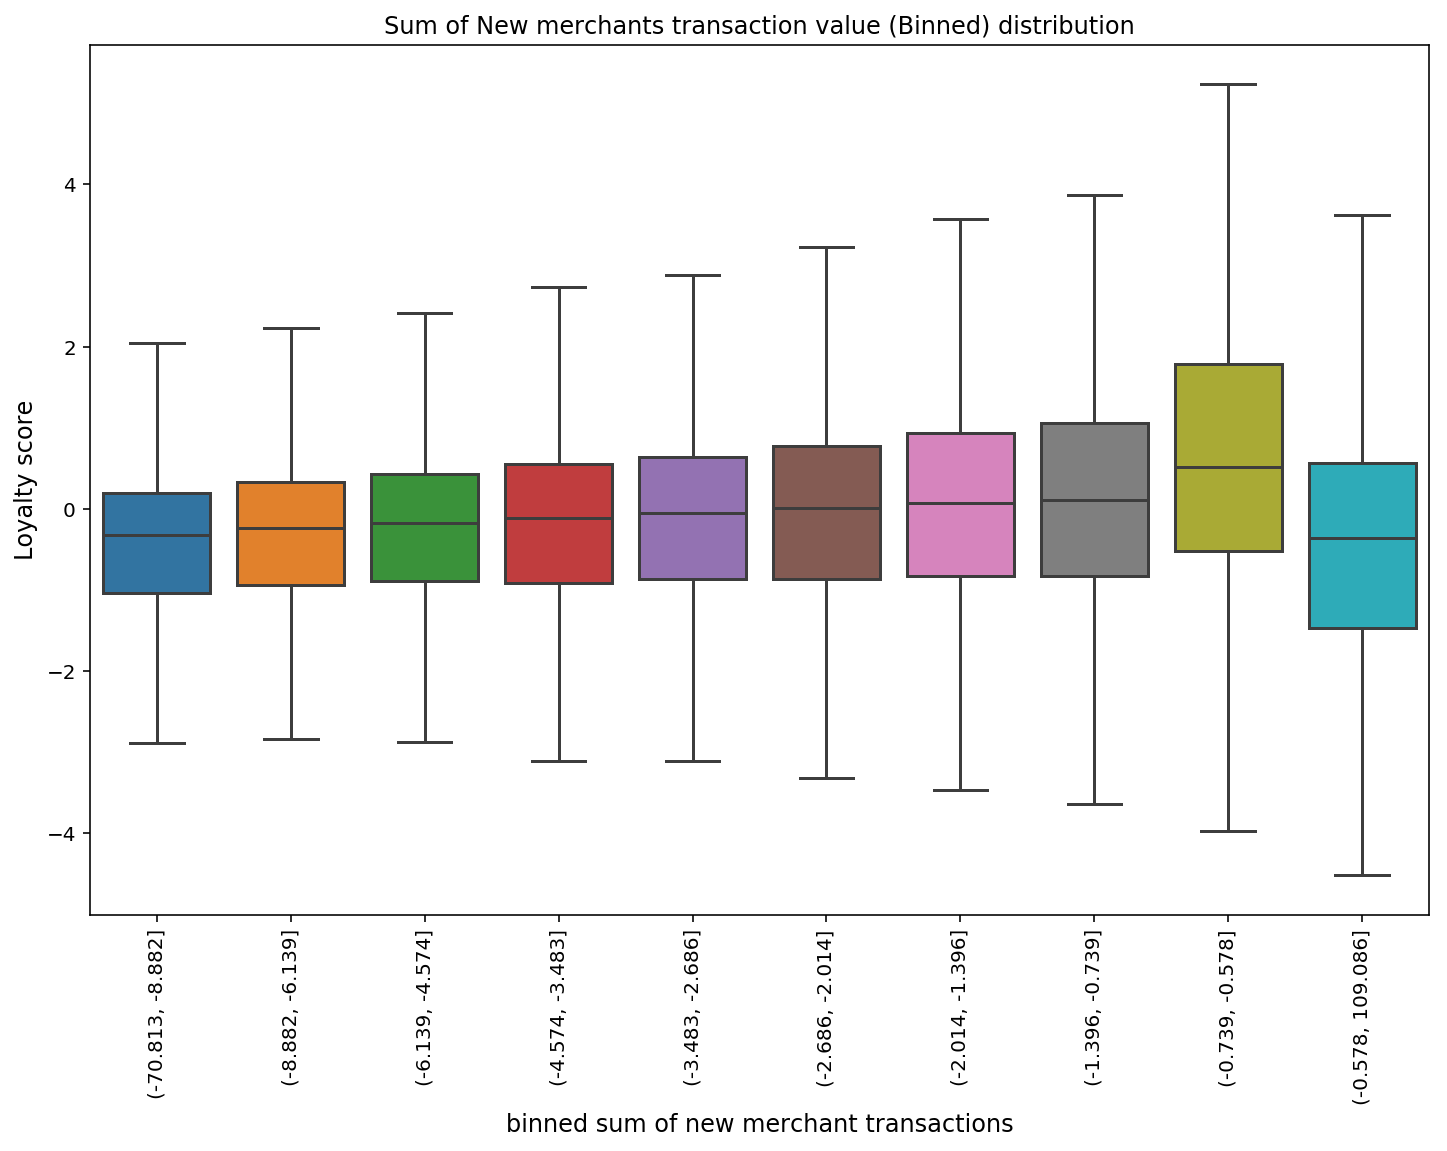

In [31]:
bins = np.nanpercentile(train_df["sum_merch_trans"], range(0,101,10))
train_df['binned_sum_merch_trans'] = pd.cut(train_df['sum_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_merch_trans", y='target', data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned sum of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of New merchants transaction value (Binned) distribution")
plt.show()

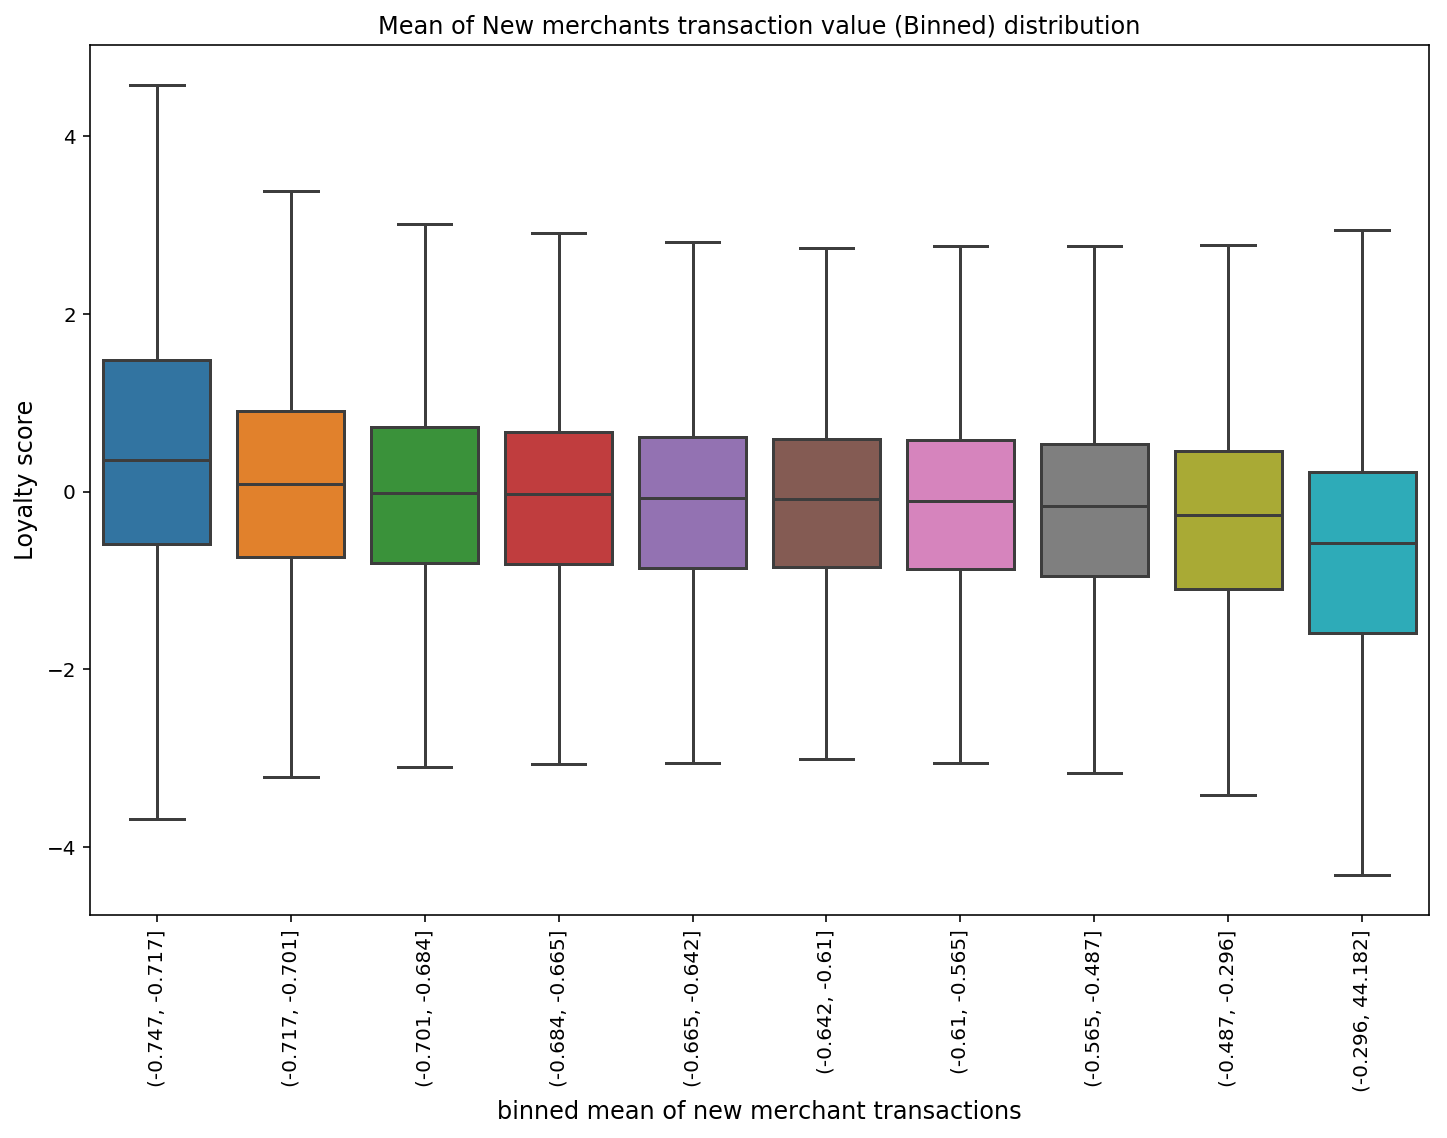

In [32]:
bins = np.nanpercentile(train_df["mean_merch_trans"], range(0,101,10))
train_df['binned_mean_merch_trans'] = pd.cut(train_df['mean_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_merch_trans", y='target', data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned mean of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of New merchants transaction value (Binned) distribution")
plt.show()

In [33]:
train_df["year"] = train_df["first_active_month"].dt.year
test_df["year"] = test_df["first_active_month"].dt.year
train_df["month"] = train_df["first_active_month"].dt.month
test_df["month"] = test_df["first_active_month"].dt.month

In [50]:
# save to base train and test
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test.csv', index=False)